# Evaluate the WGANGP Model

reload the WGANGP model and its training history and evaluate

## Import modules

In [24]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from wgangp_model import WGAN_GP, load_generator, generate_synthetic_data, inverse_transform_synthetic_data
from evaluation_protocol import calculate_emd, calculate_ks_test, calculate_js_divergence, calculate_sbasic, calculate_scorr, calculate_smirr, calculate_spca

## Set dynamic GPU memory growth

In [2]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


I0000 00:00:1736254242.918606   15536 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736254242.942735   15536 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736254242.944250   15536 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Load dataset


In [31]:
# - load dataframe (contains *physical* units!)
df_path = "datasets/newData_122500/02_h5_wide_122500_df.h5"
df_input = pd.read_hdf(df_path)
df_input = df_input.drop(columns= ["wavelength", "Q_sca", "Q_back", "Q_fwd"], axis=1)
df_input

,mat_core,mat_shell,r_core,r_shell
0,Si,Si,1,2
1,Si,SiO2,1,2
2,Si,Au,1,2
3,Si,Ag,1,2
4,Si,Si3N4,1,2
...,...,...,...,...
122495,TiO2,Au,100,200
122496,TiO2,Ag,100,200
122497,TiO2,Si3N4,100,200
122498,TiO2,ZrO2,100,200


## Load preprocessed data

In [5]:
hdf5_file_name = "datasets/newData_122500/02_dataset_preprop_train_test.hdf5"

# Open the HDF5 file
f = h5py.File(hdf5_file_name, "r")
X_train = np.array(f["X_train"])
y_train = np.array(f["y_train"])
X_test = np.array(f["X_test"])
y_test = np.array(f["y_test"])
f.close()

# Combine X_train and X_test
X_transformed = np.concatenate((X_train, X_test), axis=0)
print("Shape of X_transformed:", X_transformed.shape)
np.random.seed(42)  # Set seed for reproducibility
np.random.shuffle(X_transformed)
X_transformed

Shape of X_transformed: (122500, 16)


array([[ 0.2929293 ,  0.47474748,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.6262626 ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.47474748,  0.03030303,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.93939394,  0.27272728,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5555556 , -0.6969697 ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.25252524,  0.27272728,  0.        , ...,  0.        ,
         1.        ,  0.        ]], dtype=float32)

## Load Preprocessor

In [6]:
# Load the preprocessors and scalers
preprocessor_path = 'datasets/newData_122500/04_shuffle_features_scaler_MinMax(-1,1)_OneHot.pkl'
scaler_Qfwd_path = 'datasets/newData_122500/04_shuffle_Qfwd_target_MinMaxScaler_-1-1.pkl'
scaler_Qback_path = 'datasets/newData_122500/04_shuffle_Qback_target_MinMaxScaler_-1-1.pkl'

# Load the preprocessors and scalers
with open(preprocessor_path, 'rb') as f:
    preprocessor = pickle.load(f)
with open(scaler_Qfwd_path, 'rb') as f:
    scaler_Qfwd = pickle.load(f)
with open(scaler_Qback_path, 'rb') as f:
    scaler_Qback = pickle.load(f)


## Load Generator

In [17]:
# Load the pre-trained generator
generator = load_generator('models/wgangp_tf/newData_122500/03_generator_tf_batch122500_noise128_weight10_40000epoch_generator.h5')

# Generate synthetic data
num_samples = 10000     # Number of synthetic samples to generate
noise_dim = 128         # Dimensionality of the noise vector
synthetic_data = generate_synthetic_data(generator, noise_dim, num_samples)
synthetic_data

[<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
 array([[-0.71686345, -0.45264634],
        [-0.74670684, -0.4044537 ],
        [-0.13696009,  0.2824244 ],
        ...,
        [ 0.44256347,  0.41532302],
        [ 0.41686857, -0.11412615],
        [-0.23207283, -0.01038946]], dtype=float32)>,
 <tf.Tensor: shape=(10000, 7), dtype=float32, numpy=
 array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 1.0000000e+00],
        [7.2090134e-34, 0.0000000e+00, 0.0000000e+00, ..., 1.7574855e-24,
         0.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        ...,
        [6.4448738e-15, 4.1655693e-23, 1.0935552e-18, ..., 8.2640838e-16,
         1.0000000e+00, 3.0943486e-23],
        [0.0000000e+00, 7.4375363e-20, 0.0000000e+00, ..., 0.0000000e+00,
         1.0000000e+00, 0.0000000e+00],
        [4.2435321e-18, 3.2018298e-18, 9.6839899e-01, ..., 2.750

In [18]:
# Inverse transform synthetic data to the original scale
synthetic_data_original_scale = inverse_transform_synthetic_data(preprocessor, synthetic_data)
synthetic_data_original_scale

array([[15.0152587890625, 56.188011169433594, 'TiO2', 'Si3N4'],
       [13.538010597229004, 60.95908737182617, 'TiO2', 'SiO2'],
       [43.72047805786133, 128.9600067138672, 'Si', 'Si'],
       ...,
       [72.40689086914062, 142.11697387695312, 'ZrO2', 'Au'],
       [71.13499450683594, 89.7015151977539, 'ZrO2', 'TiO2'],
       [39.01239776611328, 99.97144317626953, 'Au', 'Au']], dtype=object)

In [20]:
# Define the desired column order
desired_columns = ['mat_core', 'mat_shell', 'r_core', 'r_shell']
generated_columns = ['r_core', 'r_shell', 'mat_core', 'mat_shell']

# Convert synthetic data to a DataFrame
synthetic_df = pd.DataFrame(synthetic_data_original_scale, columns=generated_columns)

# Reorder columns according to the desired order
synthetic_df = synthetic_df[desired_columns]
synthetic_df

,mat_core,mat_shell,r_core,r_shell
0,TiO2,Si3N4,15.015259,56.188011
1,TiO2,SiO2,13.538011,60.959087
2,Si,Si,43.720478,128.960007
3,Au,ZrO2,52.229614,73.802536
4,ZrO2,Si3N4,67.277527,118.553139
...,...,...,...,...
9995,ZrO2,TiO2,16.071367,49.497257
9996,Si3N4,ZrO2,60.665508,83.421326
9997,ZrO2,Au,72.406891,142.116974
9998,ZrO2,TiO2,71.134995,89.701515


## Plotting
---

### <u> Real Data </u>

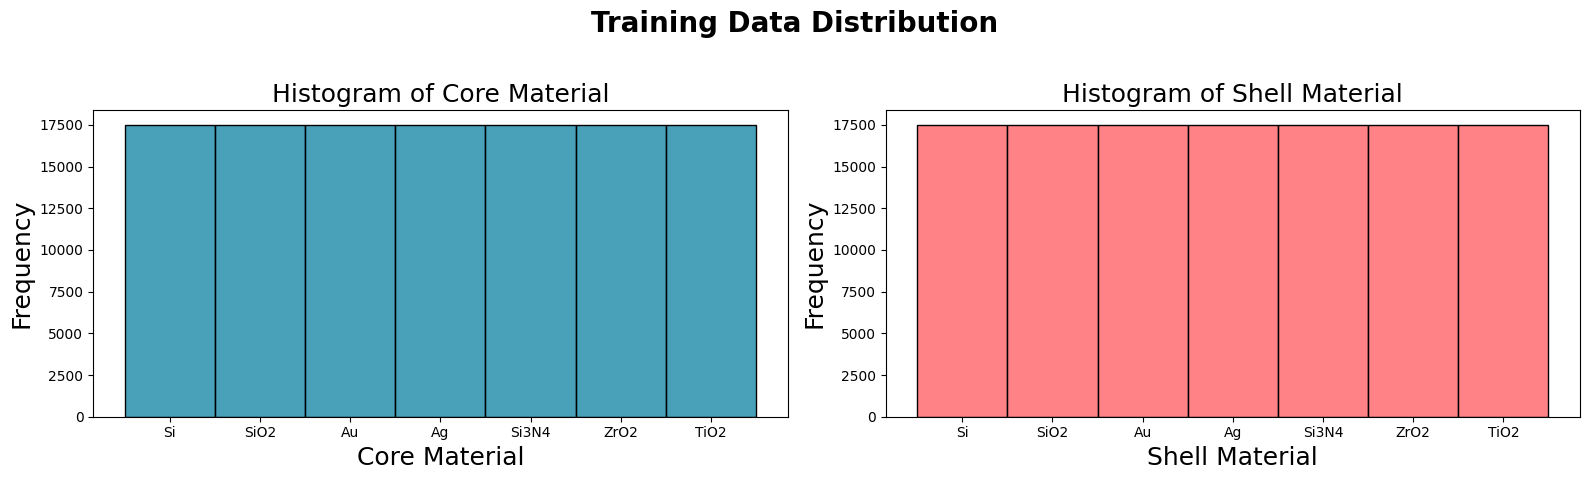

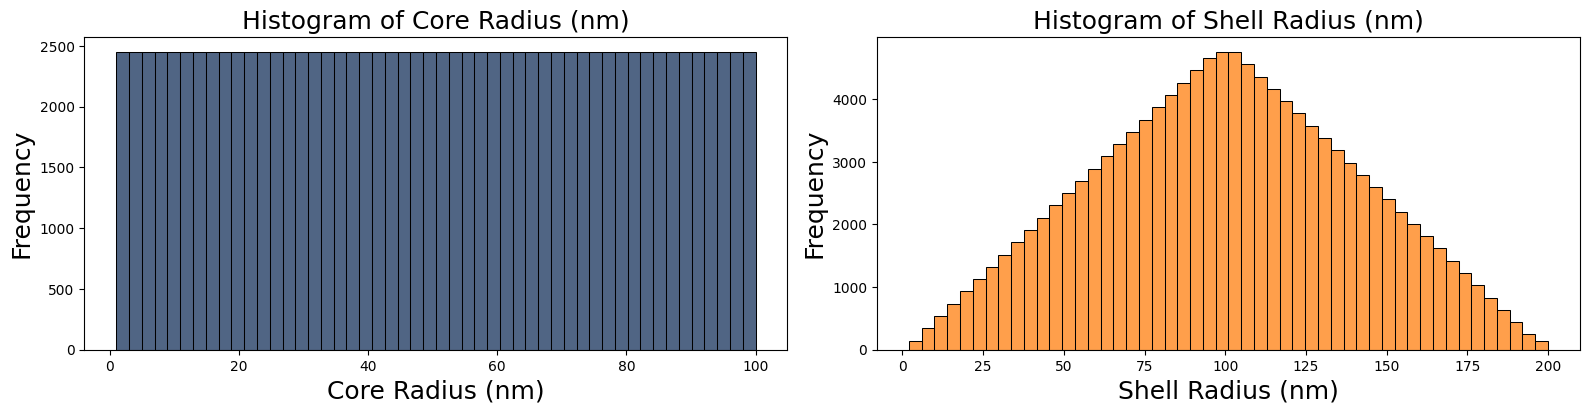

In [21]:
# Plotting histograms
fig1, axs1 = plt.subplots(1, 2, figsize=(16, 5))  # Adjust the layout and size as needed
fig1.suptitle('Training Data Distribution', fontweight='bold', fontsize=20)

# Core Material
sns.histplot(df_input['mat_core'], bins=30, color='#0b81a2ff', edgecolor='black', ax=axs1[0])
axs1[0].set_title('Histogram of Core Material', fontsize=18)
axs1[0].set_xlabel('Core Material', fontsize=18)
axs1[0].set_ylabel('Frequency', fontsize=18)

# Shell Material
sns.histplot(df_input['mat_shell'], bins=30, color='#ff5a5eff', edgecolor='black', ax=axs1[1])
axs1[1].set_title('Histogram of Shell Material', fontsize=18)
axs1[1].set_xlabel('Shell Material', fontsize=18)
axs1[1].set_ylabel('Frequency', fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
# plt.savefig("save_figures/new_plot/01_training_hist_cat.svg", bbox_inches='tight', dpi=300)   
plt.show()

# Plotting histograms for numerical features
fig2, axs2 = plt.subplots(1, 2, figsize=(16, 4.6))  # Adjust the layout and size as needed

# Core Radius (nm)
sns.histplot(df_input['r_core'], bins=50, color='#16325bff', edgecolor='black', ax=axs2[0])
axs2[0].set_title('Histogram of Core Radius (nm)', fontsize=18)
axs2[0].set_xlabel('Core Radius (nm)', fontsize=18)
axs2[0].set_ylabel('Frequency', fontsize=18)

# Shell Thickness (nm)
sns.histplot(df_input['r_shell'], bins=50, color='#ff7f0eff', edgecolor='black', ax=axs2[1])
axs2[1].set_title('Histogram of Shell Radius (nm)', fontsize=18)
axs2[1].set_xlabel('Shell Radius (nm)', fontsize=18)
axs2[1].set_ylabel('Frequency', fontsize=18)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
# plt.savefig("save_figures/new_plot/01_training_hist_num.svg", bbox_inches='tight', dpi=300)  
plt.show()


### <u> Synthetic Data </u>

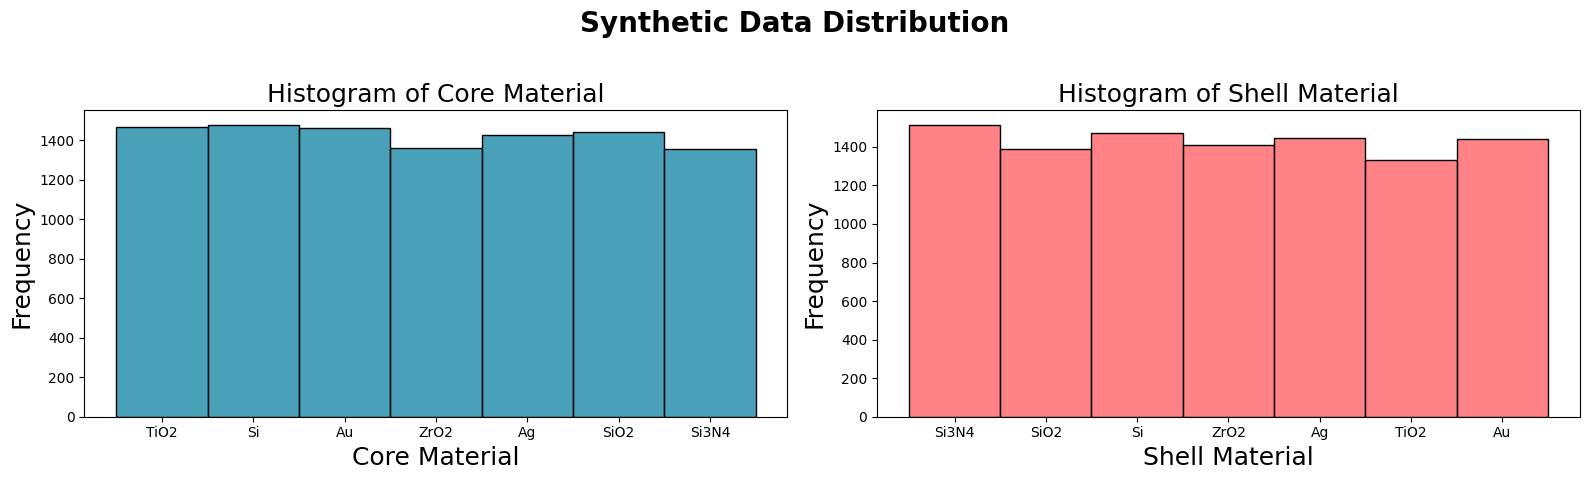

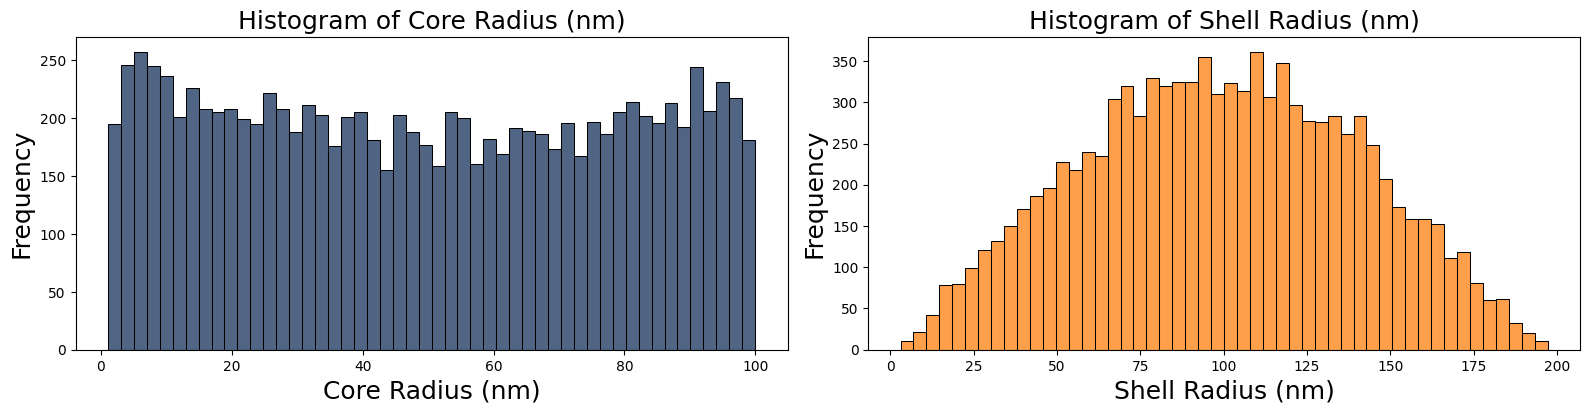

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting histograms
fig1, axs1 = plt.subplots(1, 2, figsize=(16, 5))  # Adjust the layout and size as needed
fig1.suptitle('Synthetic Data Distribution', fontweight='bold', fontsize=20)

# Core Material
sns.histplot(synthetic_df['mat_core'], bins=30, color='#0b81a2ff', edgecolor='black', ax=axs1[0])
axs1[0].set_title('Histogram of Core Material', fontsize=18)
axs1[0].set_xlabel('Core Material', fontsize=18)
axs1[0].set_ylabel('Frequency', fontsize=18)

# Shell Material
sns.histplot(synthetic_df['mat_shell'], bins=30, color='#ff5a5eff', edgecolor='black', ax=axs1[1])
axs1[1].set_title('Histogram of Shell Material', fontsize=18)
axs1[1].set_xlabel('Shell Material', fontsize=18)
axs1[1].set_ylabel('Frequency', fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  

# plt.savefig("save_figures/new_plot/01_syn_hist_cat.svg", bbox_inches='tight', dpi=300)  
plt.show()

# Plotting histograms for numerical features
fig2, axs2 = plt.subplots(1, 2, figsize=(16, 4.6))  # Adjust the layout and size as needed
#fig2.suptitle('Histograms of Numerical Features on Synthetic Data')

# Core Radius (nm)
sns.histplot(synthetic_df['r_core'], bins=50, color='#16325bff', edgecolor='black', ax=axs2[0])
axs2[0].set_title('Histogram of Core Radius (nm)', fontsize=18)
axs2[0].set_xlabel('Core Radius (nm)', fontsize=18)
axs2[0].set_ylabel('Frequency', fontsize=18)

# Shell Thickness (nm)
sns.histplot(synthetic_df['r_shell'], bins=50, color='#ff7f0eff', edgecolor='black', ax=axs2[1])
axs2[1].set_title('Histogram of Shell Radius (nm)', fontsize=18)
axs2[1].set_xlabel('Shell Radius (nm)', fontsize=18)
axs2[1].set_ylabel('Frequency', fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  

# plt.savefig("save_figures/new_plot/01_syn_hist_num.svg", bbox_inches='tight', dpi=300) 
plt.show()


## Evaluation the Quality of Synthetic data

### <u> Statisitcs Metrics </u>

In [25]:
# Add a placeholder column for 'Wavelength (nm)'

# Convert processed data back to DataFrame for easier handling
X_processed_df = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())
synthetic_processed = preprocessor.transform(synthetic_df)
synthetic_processed_df = pd.DataFrame(synthetic_processed, columns=preprocessor.get_feature_names_out())

# Ensure the feature shapes of real and synthetic data match
if X_processed_df.shape[1] != synthetic_processed_df.shape[1]:
    raise ValueError("The feature dimensions of real and synthetic data do not match even after alignment.")

# Convert to numpy array for evaluation
X_processed_arr = X_processed_df.values
X_synthetic_arr = synthetic_processed_df.values

# Normalize the data
scaler = StandardScaler()
X_real_normalized = scaler.fit_transform(X_processed_arr)
X_synthetic_normalized = scaler.transform(X_synthetic_arr)

# Sample the real dataset to match the size of the synthetic dataset
sampled_indices = np.random.choice(X_real_normalized.shape[0], X_synthetic_normalized.shape[0], replace=False)
X_real_sampled = X_real_normalized[sampled_indices]

In [26]:
# Calculate similarity metrics
emd_score = calculate_emd(X_real_normalized, X_synthetic_normalized)
ks_stats = calculate_ks_test(X_real_normalized, X_synthetic_normalized)
js_divs = calculate_js_divergence(X_real_normalized, X_synthetic_normalized)

sbasic = calculate_sbasic(X_real_sampled, X_synthetic_normalized)
scorr = calculate_scorr(X_real_sampled, X_synthetic_normalized)
smirr = calculate_smirr(X_real_sampled, X_synthetic_normalized)
spca = calculate_spca(X_real_sampled, X_synthetic_normalized)

# List of all similarity metrics
similarity_metrics = [sbasic, scorr, smirr, spca]

# Calculate the overall similarity score
SS = np.mean(similarity_metrics)

print(f"EMD Score: {emd_score}")
print(f"KS Test Statistics: {ks_stats}")
print(f"JS Divergence: {js_divs}")
print(f"Sbasic: {sbasic}")
print(f"Scorr: {scorr}")
print(f"Smirr: {smirr}")
print(f"Spca: {spca}")
print(f"SS: {SS}")


EMD Score: 0.014913411750001762
KS Test Statistics: {'Feature 0': 0.02839999999999998, 'Feature 1': 0.027700000000000002, 'Feature 2': 0.8571428571428571, 'Feature 3': 0.8571428571428571, 'Feature 4': 0.8571428571428571, 'Feature 5': 0.8571428571428571, 'Feature 6': 0.8571428571428571, 'Feature 7': 0.8571428571428571, 'Feature 8': 0.8571428571428571, 'Feature 9': 0.8571428571428571, 'Feature 10': 0.8571428571428571, 'Feature 11': 0.8571428571428571, 'Feature 12': 0.8571428571428571, 'Feature 13': 0.8571428571428571, 'Feature 14': 0.8571428571428571, 'Feature 15': 0.8571428571428571}
JS Divergence: {'Feature 0': 0.029249091044324292, 'Feature 1': 0.02439071905693578, 'Feature 2': 0.004958664216252603, 'Feature 3': 0.0014547315117745142, 'Feature 4': 0.003561276953645661, 'Feature 5': 0.00015883353338549182, 'Feature 6': 0.00751527410335341, 'Feature 7': 0.006689961230511242, 'Feature 8': 0.0041608342992326686, 'Feature 9': 0.004460231459210294, 'Feature 10': 0.0040215728220269285, 'Feat

### <u> Pairwise scatter Plot </u>


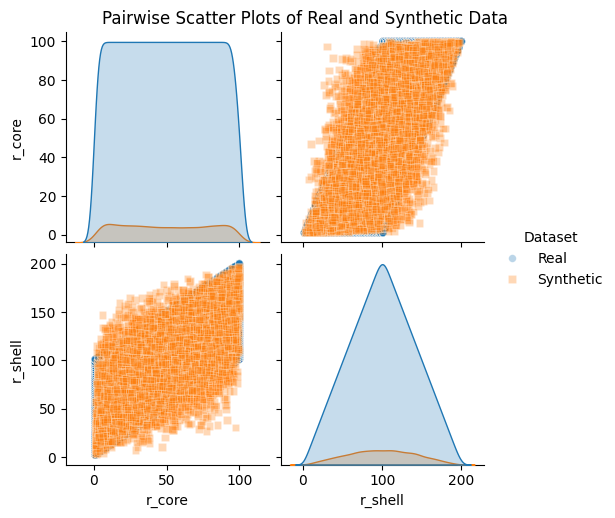

In [32]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `X` is your real data and `synthetic_df` is your synthetic data

# Add a column to distinguish between real and synthetic data
df_input['Dataset'] = 'Real'
synthetic_df['Dataset'] = 'Synthetic'

# Combine the datasets
combined_df = pd.concat([df_input, synthetic_df], ignore_index=True)

# Plot pairwise scatter plots
pairplot = sns.pairplot(combined_df, hue='Dataset', markers=["o", "s"], plot_kws={'alpha':0.3, 's':30})
pairplot.fig.suptitle('Pairwise Scatter Plots of Real and Synthetic Data', y=1.02)

plt.savefig("save_figures/02_pairwise_num.pdf")   
plt.show()
